In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [11]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
#Vacations date
query_result = calc_temps('2017-08-01','2017-08-07')
query_result[0]

(72.0, 79.25, 83.0)

Text(0.5, 1.0, 'Trip Avg Temp')

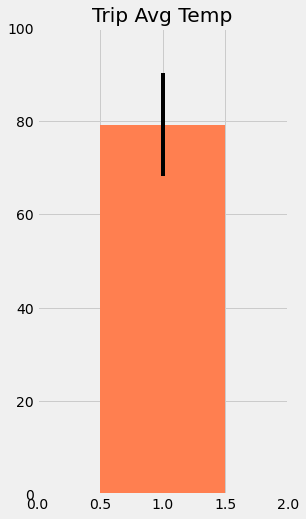

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
TMIN = query_result[0][0]
TAVE = query_result[0][1]
TMAX = query_result[0][2]
ptp = TMAX-TMIN
plt.figure(figsize=(4,8))
plt.bar(1,TAVE,yerr = ptp,color='coral',width=1)
plt.xlim(0,2)
plt.ylim(0,100)
plt.title("Trip Avg Temp")

### Daily Rainfall Average

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
from sqlalchemy import func,asc,desc
daily_rainfall_avg = session.query(func.avg(Measurement.prcp),Station.id,Station.name,Station.latitude,Station.longitude).\
filter(Measurement.station==Station.station).filter(Measurement.date>='2017-08-01').filter(Measurement.date<='2017-08-07'). \
group_by(Measurement.station).order_by(func.avg(Measurement.prcp).desc()).all()
for daily in daily_rainfall_avg:
    print(daily)

(0.12, 9, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025)
(0.03666666666666667, 3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374)
(0.02, 7, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998)
(0.005714285714285714, 1, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168)
(0.0, 6, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139)


In [49]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [77]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
from datetime import datetime,timedelta
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

start_date_x = datetime.strptime(start_date, '%Y-%m-%d')
end_date_x = datetime.strptime(end_date, '%Y-%m-%d')

date_list = [start_date_x]

delta = timedelta(days=1)
while start_date_x < end_date_x:
    start_date_x += delta
    date_list.append(start_date_x)

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
md_list = []
for date in date_list:
    md_list.append(date.strftime("%m-%d"))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals= [daily_normals(x) for x in md_list]
tmin =  [x[0][0] for x in normals]
tavg =  [x[0][1] for x in normals]
tmax =  [x[0][2] for x in normals]


In [93]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame({"tmin":tmin,"tavg":tavg,"tmax":tmax,"date":md_list})
df.set_index("date")

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.]),
 [Text(-1.0, 0, '08-07'),
  Text(0.0, 0, '08-01'),
  Text(1.0, 0, '08-02'),
  Text(2.0, 0, '08-03'),
  Text(3.0, 0, '08-04'),
  Text(4.0, 0, '08-05'),
  Text(5.0, 0, '08-06'),
  Text(6.0, 0, '08-07'),
  Text(7.0, 0, '')])

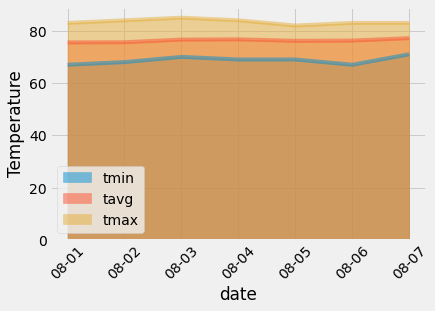

In [94]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False,x="date")
plt.ylabel("Temperature")
plt.xticks(rotation=45)

## Close Session

In [95]:
session.close()